In this notebook, I have run linear regressions on heat and hot water complaints in Bronx in 2021 to find out if there exists a relationship between the number of complaints and a census tract's racial makeup and poverty level.

In [11]:
# make all the imports

%load_ext rpy2.ipython
%load_ext autoreload
%autoreload 2

%matplotlib inline  
from matplotlib import rcParams
rcParams['figure.figsize'] = (16, 100)

import warnings
from rpy2.rinterface import RRuntimeWarning
warnings.filterwarnings("ignore") # Ignore all warnings
# warnings.filterwarnings("ignore", category=RRuntimeWarning) # Show some warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
%%R

require('tidyverse')
require('ggrepel')
require('ggpubr')
require('broom')
require('AICcmodavg')

R[write to console]: Loading required package: tidyverse



── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.0      ✔ purrr   1.0.1 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.3.0      ✔ stringr 1.5.0 
✔ readr   2.1.3      ✔ forcats 1.0.0 
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


R[write to console]: Loading required package: ggrepel

R[write to console]: Loading required package: ggpubr

R[write to console]: Loading required package: broom

R[write to console]: Loading required package: AICcmodavg



In [13]:
df = pd.read_csv('bronx_2021_merged.csv')
df

,pop_2021,tract,complaints,pct_white,pct_black,pct_asian,hispanic,pct_hispanic,pct_below_poverty,complaints_norm
0,4453,200,108.0,27.734112,28.340445,3.593083,3180,71.412531,19.971264,242.533124
1,6000,400,46.0,30.150000,24.533333,2.950000,4386,73.100000,4.865848,76.666667
2,6038,1600,110.0,16.495528,38.456443,1.076515,3364,55.713813,24.051212,182.179530
3,2168,1901,189.0,30.627306,40.036900,0.000000,1155,53.274908,28.361582,871.771218
4,1399,1902,64.0,20.800572,31.165118,3.931380,650,46.461758,19.148936,457.469621
...,...,...,...,...,...,...,...,...,...,...
335,6351,46207,20.0,7.920013,62.068966,4.204062,2038,32.089435,17.654987,31.491104
336,5879,46208,74.0,9.780575,67.970743,0.136078,1913,32.539548,15.912117,125.871747
337,5039,46209,31.0,8.057154,64.397698,0.079381,2214,43.937289,34.946237,61.520143
338,4213,48401,28.0,5.672917,82.150487,0.000000,488,11.583195,6.866614,66.460954


In [33]:
# zero pad the tract code 5 digits

df['tract_code'] = df['tract'].astype(str)
df['tract_code'] = '005'+df['tract_code'].str.zfill(6)
df



,pop_2021,tract,complaints,pct_white,pct_black,pct_asian,hispanic,pct_hispanic,pct_below_poverty,complaints_norm,tract_code
0,4453,200,108.0,27.734112,28.340445,3.593083,3180,71.412531,19.971264,242.533124,005000200
1,6000,400,46.0,30.150000,24.533333,2.950000,4386,73.100000,4.865848,76.666667,005000400
2,6038,1600,110.0,16.495528,38.456443,1.076515,3364,55.713813,24.051212,182.179530,005001600
3,2168,1901,189.0,30.627306,40.036900,0.000000,1155,53.274908,28.361582,871.771218,005001901
4,1399,1902,64.0,20.800572,31.165118,3.931380,650,46.461758,19.148936,457.469621,005001902
...,...,...,...,...,...,...,...,...,...,...,...
335,6351,46207,20.0,7.920013,62.068966,4.204062,2038,32.089435,17.654987,31.491104,005046207
336,5879,46208,74.0,9.780575,67.970743,0.136078,1913,32.539548,15.912117,125.871747,005046208
337,5039,46209,31.0,8.057154,64.397698,0.079381,2214,43.937289,34.946237,61.520143,005046209
338,4213,48401,28.0,5.672917,82.150487,0.000000,488,11.583195,6.866614,66.460954,005048401


In [34]:
#save as csv

df.to_csv('bronx_tract_code.csv', index=False)

## What is in the dataframe?

This is a dataframe of 311 complaints related to heat and hot in Bronx, New York City registered in 2021. The data has been downloaded from the [NYC Open Data Portal](https://opendata.cityofnewyork.us/) and merged with US census tract level data.


| Columns  | Explanation |
| ------------- | ------------- |
| complaints | Number of complaints (raw number) filed in 2021 |
| pct_below_poverty | Percentage of people below poverty line in the census tract |
| pct_white | Percentage of white people in the census tract |
| pct_black	| Percentage of black or african american people in the census tract |
| pct_asian | Percentage of asian people in the census tract |
| pct_hispanic | Percentage of hispanic or latino people in the zip code |
| complaints_norm | Complaints per 10,000 people in the census tract in 2021 |


#### First hypothesis

There is no relationship between the number of heat and hot water complaints and the number of people living below poverty in a census tract.

`geom_smooth()` using formula = 'y ~ x'


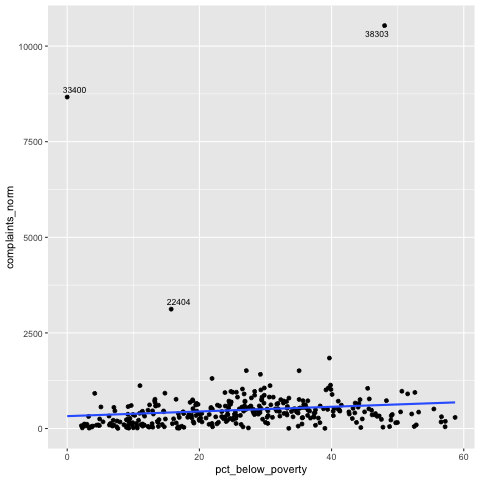

In [19]:
%%R -i df 

ggplot(df, aes(x = pct_below_poverty, y = complaints_norm)) +
    geom_text_repel(data = subset(df, complaints_norm > 2500), aes(label = tract), size = 3) +
    geom_point() +
    geom_smooth(method = "lm", se = FALSE)

#### Notes: 

2176 Tiebout Avenue is the address that my story is looking at and it is located in census tract 38303. There were 10499 complaints from this tract in 2021 and of those 3707 complaints were from 2176 Tiebout Avenue which is 35.3% of the total complaints from the tract.

The chart above has plotted complaints normalized by population of the census tracts, i.e, complaints per 10,000 people.

In [16]:
%%R -i df

model <- lm(complaints_norm ~ pct_below_poverty, data=df)
summary(model)



Call:
lm(formula = complaints_norm ~ pct_below_poverty, data = df)

Residuals:
   Min     1Q Median     3Q    Max 
-627.4 -264.0 -102.0   92.2 9917.6 

Coefficients:
                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)        323.682     91.187   3.550  0.00044 ***
pct_below_poverty    6.118      3.123   1.959  0.05093 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 777.2 on 338 degrees of freedom
Multiple R-squared:  0.01123,	Adjusted R-squared:  0.008301 
F-statistic: 3.838 on 1 and 338 DF,  p-value: 0.05093



Since the p-value is not less than 0.05, the null hypothesis cannot be rejected. This means that there is no statistically significant relationship between the number of heat and hot water complaints and the number of people living below poverty in a census tract.

#### Second hypothesis

There is no relationship between the number of heat and hot water complaints and the racial makeup of a census tract.

`geom_smooth()` using formula = 'y ~ x'


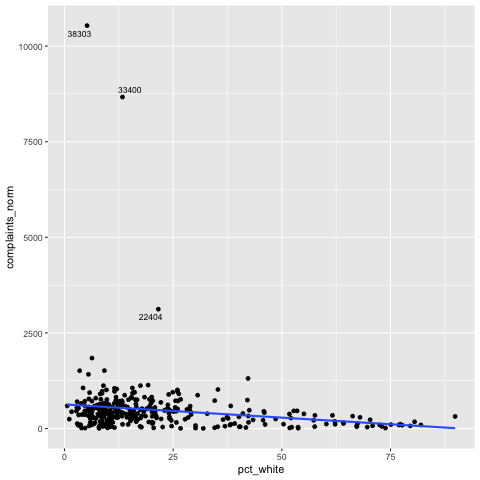

In [20]:
%%R -i df 

ggplot(df, aes(x = pct_white, y = complaints_norm)) +
    geom_text_repel(data = subset(df, complaints_norm > 2500), aes(label = tract), size = 3) +
    geom_point() +
    geom_smooth(method = "lm", se = FALSE)

In [27]:
%%R -i df

model <- lm(complaints_norm ~ pct_hispanic + pct_black + pct_below_poverty, data=df)
summary(model)


Call:
lm(formula = complaints_norm ~ pct_hispanic + pct_black + pct_below_poverty, 
    data = df)

Residuals:
   Min     1Q Median     3Q    Max 
-562.9 -248.7  -85.0  107.6 9999.0 

Coefficients:
                  Estimate Std. Error t value Pr(>|t|)  
(Intercept)        -14.220    175.164  -0.081   0.9353  
pct_hispanic         6.038      3.024   1.996   0.0467 *
pct_black            4.827      2.430   1.987   0.0478 *
pct_below_poverty    0.194      4.219   0.046   0.9633  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 773.7 on 336 degrees of freedom
Multiple R-squared:  0.02602,	Adjusted R-squared:  0.01732 
F-statistic: 2.992 on 3 and 336 DF,  p-value: 0.03104



`geom_smooth()` using formula = 'y ~ x'


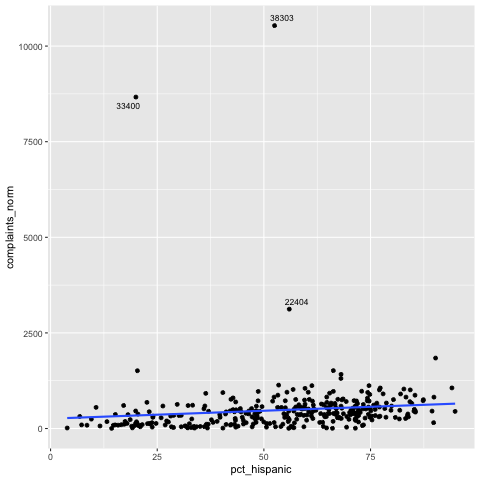

In [21]:
%%R -i df 

ggplot(df, aes(x = pct_hispanic, y = complaints_norm)) +
    geom_text_repel(data = subset(df, complaints_norm > 2500), aes(label = tract), size = 3) +
    geom_point() +
    geom_smooth(method = "lm", se = FALSE)

In [23]:
%%R -i df

model <- lm(complaints_norm ~ pct_hispanic, data=df)
summary(model)


Call:
lm(formula = complaints_norm ~ pct_hispanic, data = df)

Residuals:
    Min      1Q  Median      3Q     Max 
 -545.7  -255.7  -111.2    83.5 10060.1 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)  
(Intercept)   257.968    119.019   2.167   0.0309 *
pct_hispanic    4.134      2.053   2.013   0.0449 *
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 776.9 on 338 degrees of freedom
Multiple R-squared:  0.01185,	Adjusted R-squared:  0.008929 
F-statistic: 4.054 on 1 and 338 DF,  p-value: 0.04486



`geom_smooth()` using formula = 'y ~ x'


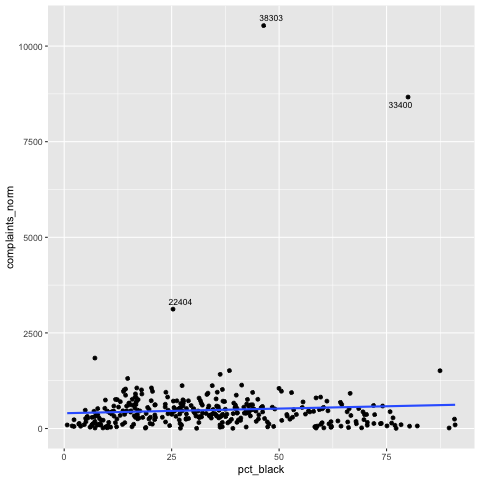

In [24]:
%%R -i df 

ggplot(df, aes(x = pct_black, y = complaints_norm)) +
    geom_text_repel(data = subset(df, complaints_norm > 2500), aes(label = tract), size = 3) +
    geom_point() +
    geom_smooth(method = "lm", se = FALSE)